# Homework 1: Preprocessing data

## 環境設定

請先安裝以下套件：

```bash
pip install matplotlib==3.10.1 numpy==2.2.3 pandas==2.2.3 plotly==6.0.0 scikit-learn==1.6.1 scipy==1.15.2 seaborn==0.13.2 ucimlrepo==0.0.7
```

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [19]:
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## Import data from UCI machine learning repository

In [20]:
# fetch dataset
mushroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
assert mushroom.data is not None
assert isinstance(mushroom.data.features, pd.DataFrame)
assert isinstance(mushroom.data.targets, pd.DataFrame)

X = mushroom.data.features
y = mushroom.data.targets

## 缺失值處理 - missing values

In [21]:
# Check missing values
missing_values = X.isnull().sum()
print("特徵缺失值：")
print(missing_values)

missing_values_y = y.isnull().sum()
print("\n目標變數缺失值：")
print(missing_values_y)

特徵缺失值：
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64

目標變數缺失值：
poisonous    0
dtype: int64


很明顯 stalk-root 有一個缺失值。查看缺失值相對於所有值的比例。

In [22]:
missing_ratio = X.isnull().sum().sum() / X.shape[0]
print(f"缺失值比例：{missing_ratio:.2%}")

缺失值比例：30.53%


居然有 30%！要不就刪除這一個 column 好了 …

In [23]:
# drop 'stalk-root' column and meaningless column
Xc = X.drop(columns=['stalk-root', 'veil-type'])

## 針對資料進行敘述統計

### 資料基本資訊

In [24]:
print("資料集大小：\t", X.shape)
print("特徵數量：\t", X.shape[1])
print("樣本數量：\t", X.shape[0])

資料集大小：	 (8124, 22)
特徵數量：	 22
樣本數量：	 8124


### 這份資料集中，有多少是有毒，有多少是無毒的？

In [25]:
fig = px.histogram(y, x="poisonous", color="poisonous", title="Number of poisonous and edible mushrooms")
fig.show()

### 各特徵的唯一值數量及其項目

In [26]:
# 各特徵的唯一值數量及其項目
for _col in Xc.columns:
    print(f"\n{_col}: {Xc[_col].nunique()} 個唯一值")
    print(Xc[_col].value_counts())

# 建立一個包含每個特徵的唯一值數量和項目的DataFrame
features_info = []
for _col in Xc.columns:
    _unique_values = Xc[_col].unique().tolist()
    features_info.append({
        'feature': _col,
        'unique_count': Xc[_col].nunique(),
        'values': _unique_values
    })

features_info_df = pd.DataFrame(features_info)
features_info_df


cap-shape: 6 個唯一值
cap-shape
x    3656
f    3152
k     828
b     452
s      32
c       4
Name: count, dtype: int64

cap-surface: 4 個唯一值
cap-surface
y    3244
s    2556
f    2320
g       4
Name: count, dtype: int64

cap-color: 10 個唯一值
cap-color
n    2284
g    1840
e    1500
y    1072
w    1040
b     168
p     144
c      44
u      16
r      16
Name: count, dtype: int64

bruises: 2 個唯一值
bruises
f    4748
t    3376
Name: count, dtype: int64

odor: 9 個唯一值
odor
n    3528
f    2160
y     576
s     576
a     400
l     400
p     256
c     192
m      36
Name: count, dtype: int64

gill-attachment: 2 個唯一值
gill-attachment
f    7914
a     210
Name: count, dtype: int64

gill-spacing: 2 個唯一值
gill-spacing
c    6812
w    1312
Name: count, dtype: int64

gill-size: 2 個唯一值
gill-size
b    5612
n    2512
Name: count, dtype: int64

gill-color: 12 個唯一值
gill-color
b    1728
p    1492
w    1202
n    1048
g     752
h     732
u     492
k     408
e      96
y      86
o      64
r      24
Name: count, dtype: int64

st

,feature,unique_count,values
0,cap-shape,6,"[x, b, s, f, k, c]"
1,cap-surface,4,"[s, y, f, g]"
2,cap-color,10,"[n, y, w, g, e, p, b, u, c, r]"
3,bruises,2,"[t, f]"
4,odor,9,"[p, a, l, n, f, c, y, s, m]"
5,gill-attachment,2,"[f, a]"
6,gill-spacing,2,"[c, w]"
7,gill-size,2,"[n, b]"
8,gill-color,12,"[k, n, g, p, w, h, u, e, b, r, y, o]"
9,stalk-shape,2,"[e, t]"


### 各特徵的值分佈

In [27]:
for _col in Xc.columns:
    _value_counts = Xc[_col].value_counts()
    fig = px.bar(_value_counts, title=f"{_col} value counts")
    fig.show()

### 特徵與毒性的關係

In [28]:
for col in Xc.columns[:5]:
    cross_tab = pd.crosstab(Xc[col], y['poisonous'], normalize='index') * 100
    print(f"\n{col} 與毒性的關係 (百分比):")
    print(cross_tab.round(2))


cap-shape 與毒性的關係 (百分比):
poisonous       e       p
cap-shape                
b           89.38   10.62
c            0.00  100.00
f           50.63   49.37
k           27.54   72.46
s          100.00    0.00
x           53.28   46.72

cap-surface 與毒性的關係 (百分比):
poisonous        e       p
cap-surface               
f            67.24   32.76
g             0.00  100.00
s            44.76   55.24
y            46.36   53.64

cap-color 與毒性的關係 (百分比):
poisonous       e      p
cap-color               
b           28.57  71.43
c           72.73  27.27
e           41.60  58.40
g           56.09  43.91
n           55.34  44.66
p           38.89  61.11
r          100.00   0.00
u          100.00   0.00
w           69.23  30.77
y           37.31  62.69

bruises 與毒性的關係 (百分比):
poisonous      e      p
bruises                
f          30.67  69.33
t          81.52  18.48

odor 與毒性的關係 (百分比):
poisonous      e      p
odor                   
a          100.0    0.0
c            0.0  100.0
f            0.0  

## Label 分類數值

### 針對 Binary 資料使用 label encoder

In [29]:
Xc_encoded_part1 = Xc.copy()

binary_features = features_info_df[features_info_df["unique_count"] <= 2]

le = LabelEncoder()
for col in binary_features["feature"]:
    Xc_encoded_part1[col] = le.fit_transform(Xc_encoded_part1[col])

### 針對 Non-binary 資料使用 one-hot encoder

In [30]:
onehot_features = features_info_df[features_info_df["unique_count"] > 2]

Xc_encoded = pd.get_dummies(Xc_encoded_part1, columns=onehot_features["feature"], dtype='int64')

## Heatmap

In [31]:
Xc_encoded_purelabel = Xc.reset_index(drop=True).copy()

_le = LabelEncoder()
for _col in features_info_df["feature"]:
    Xc_encoded_purelabel[_col] = _le.fit_transform(Xc_encoded_part1[_col])

Xc_encoded_purelabel_corr = Xc_encoded_purelabel.corr()

fig = px.imshow(Xc_encoded_purelabel_corr,
              labels=dict(x="Columns", y="Columns", color="Correlation"),
              color_continuous_scale="Viridis",
              title="Correlation Heatmap of Xc_encoded_purelabel")
fig.show()

## 切割資料集與訓練集

In [32]:
X_train, X_test, y_train, y_test = train_test_split(Xc_encoded, y, test_size=0.2, random_state=42, stratify=y)

### 資料分布

In [33]:
fig1 = px.histogram(y_train, x="poisonous", color="poisonous", title="Number of poisonous and edible mushrooms in y_train")
fig1.show()

fig2 = px.histogram(y_test, x="poisonous", color="poisonous", title="Number of poisonous and edible mushrooms in y_test")
fig2.show()

## 縮放特徵

分別使用 StandardScaler 和 MinMaxScaler 進行測試。

In [34]:
# StandardScaler
ss_scaler = StandardScaler()
ss_scaler.set_output(transform="pandas")
X_train_ss_scaled = ss_scaler.fit_transform(X_train)
X_test_ss_scaled = ss_scaler.transform(X_test)

# MinMaxScaler
mm_scaler = MinMaxScaler()
mm_scaler.set_output(transform="pandas")
X_train_mm_scaled = mm_scaler.fit_transform(X_train)
X_test_mm_scaled = mm_scaler.transform(X_test)

## Experiments: Check the Random Forest accuracy with different scaling methods

Random Forest with No Scaling:
Accuracy: 1.0000
              precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


Random Forest with StandardScaler:
Accuracy: 1.0000
              precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


Random Forest with MinMaxScaler:
Accuracy: 1.0000
              precision    recall  f1-score   support

           e       1.00      1.00      1.00       842
           p       1.00      1.00      1.00       783

    accuracy                  

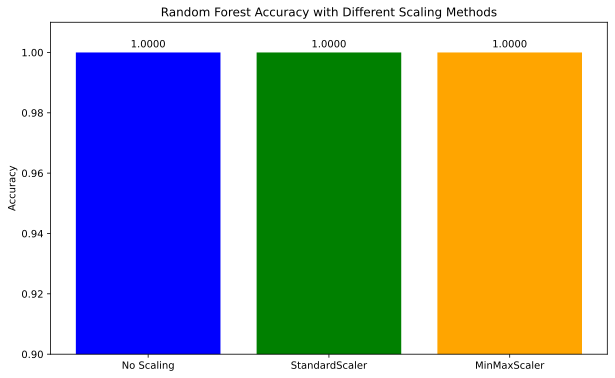

In [35]:
# Convert target to 1D array for sklearn
y_train_values = y_train['poisonous'].values
y_test_values = y_test['poisonous'].values

# Create and train models with different scaling methods
# 1. No scaling
rf_no_scaling = RandomForestClassifier(random_state=42)
rf_no_scaling.fit(X_train, y_train_values)
y_pred_no_scaling = rf_no_scaling.predict(X_test)
accuracy_no_scaling = accuracy_score(y_test_values, y_pred_no_scaling)

# 2. StandardScaler
rf_ss = RandomForestClassifier(random_state=42)
rf_ss.fit(X_train_ss_scaled, y_train_values)
y_pred_ss = rf_ss.predict(X_test_ss_scaled)
accuracy_ss = accuracy_score(y_test_values, y_pred_ss)

# 3. MinMaxScaler
rf_mm = RandomForestClassifier(random_state=42)
rf_mm.fit(X_train_mm_scaled, y_train_values)
y_pred_mm = rf_mm.predict(X_test_mm_scaled)
accuracy_mm = accuracy_score(y_test_values, y_pred_mm)

# Print results
print("Random Forest with No Scaling:")
print(f"Accuracy: {accuracy_no_scaling:.4f}")
print(classification_report(y_test_values, y_pred_no_scaling))

print("\nRandom Forest with StandardScaler:")
print(f"Accuracy: {accuracy_ss:.4f}")
print(classification_report(y_test_values, y_pred_ss))

print("\nRandom Forest with MinMaxScaler:")
print(f"Accuracy: {accuracy_mm:.4f}")
print(classification_report(y_test_values, y_pred_mm))

# Compare accuracies with a bar plot
scaling_methods = ['No Scaling', 'StandardScaler', 'MinMaxScaler']
accuracies = [accuracy_no_scaling, accuracy_ss, accuracy_mm]

plt.figure(figsize=(10, 6))
bars = plt.bar(scaling_methods, accuracies, color=['blue', 'green', 'orange'])
plt.ylim(0.9, 1.01)  # Adjust y-axis to better see differences
plt.title('Random Forest Accuracy with Different Scaling Methods')
plt.ylabel('Accuracy')

# Add accuracy values on top of bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{acc:.4f}', ha='center', va='bottom')

plt.show()